In [308]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import folium
from folium import plugins
from folium.plugins import HeatMap

plt.rcParams["font.family"] = "Garamond"
plt.rcParams['axes.facecolor'] = "#E8ECEB"
plt.rcParams['axes.facecolor'] = "#E8ECEB"

In [309]:
cols_of_interest = ['Opened', 'Closed', 'Updated', 'Status', 'Status Notes', 'Responsible Agency', 'Category', 'Request Type', 'Request Details', 'Address', 'Supervisor District', 'Neighborhood', 'Latitude', 'Longitude', 'Source', 'Media URL']

data = pd.read_csv('/Users/Gustav/Downloads/311_Cases0105.csv', usecols=cols_of_interest)
# convert to datetime
data['Opened'] = pd.to_datetime(data['Opened'])
# create a column called yearmonth that contain the year and month of the opened date
data['yearmonth'] = data['Opened'].apply(lambda x: str(x.year) + '-' + str(x.month) + '-01')

/var/folders/1j/15c8wxfx0rz57_sf9j19y3fh0000gp/T/ipykernel_74579/4132392978.py:3: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/Gustav/Downloads/311_Cases0105.csv', usecols=cols_of_interest)


# Data characteristics

In [206]:
data.columns

Index(['Opened', 'Closed', 'Updated', 'Status', 'Status Notes',
       'Responsible Agency', 'Category', 'Request Type', 'Request Details',
       'Address', 'Supervisor District', 'Neighborhood', 'Latitude',
       'Longitude', 'Source', 'Media URL', 'yearmonth'],
      dtype='object')

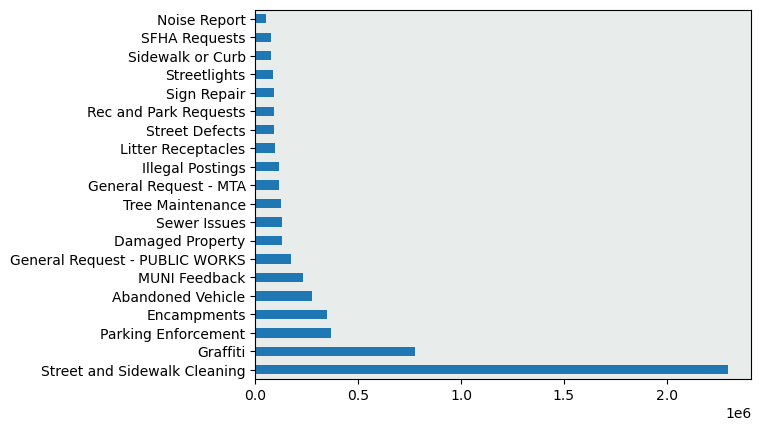

In [207]:
# only show top 10
data['Category'].value_counts().sort_values(ascending=False).head(20).plot(kind='barh')
plt.show()

# Dataframe for time series plot
1. Create a dataframe with the number of cases per month per year per request type
2. Due to changes in data format over time, we need to do some data cleaning
    - Remove rows with missing latitude and longitude
    - Combine columns that represent same type of request type
3. Based on new dataframe with combined request types, we take the types that are most interesting to us
    - We choose the request types that are most frequent - all of them are above 10000 cases in total over all years (2008-2023)
4. Plot the dataframe with the selected types using a Bokeh interactive chart that allows the user to toggle types and see patterns over time

In [208]:
data['yearmonth']

0          2008-12-01
1          2008-12-01
2          2008-12-01
3          2008-12-01
4          2008-12-01
              ...    
6105823     2020-8-01
6105824     2020-8-01
6105825     2020-8-01
6105826     2020-8-01
6105827     2020-8-01
Name: yearmonth, Length: 6105828, dtype: object

In [ ]:
# take dataframe and get a count of every Request Details value summed by month and year
df = data[(data['Category']=="Street and Sidewalk Cleaning")]
# remove rows where latitude or longitude is null or zero
df = df[(df['Latitude']!=0) | (df['Longitude']!=0)]
time_series = df.groupby([data['yearmonth']])['Request Details'].value_counts().unstack()

In [ ]:
### Fix columns that have different names but are the same
## Garbage and Debris
time_series['Loose Garbage and Debris'] = time_series["Other Loose Garbage"] + time_series["Other Loose Garbage / Debris"] + time_series["Auto_accident_debris"] + time_series['Garbage and Debris - N/A'] + time_series['Garbage and Debris - {{nature_of_request.label}}'] + time_series['Garbage and Debris - {{request_type.label}}']
# drop the old columns
time_series.drop(["Other Loose Garbage", "Other Loose Garbage / Debris", "Auto_accident_debris", 'Garbage and Debris - N/A', 'Garbage and Debris - {{nature_of_request.label}}', 'Garbage and Debris - {{request_type.label}}'], axis=1, inplace=True)

## Overflowing city garbage can
time_series['Overflowing City Garbage Can'] = time_series['City_garbage_can_overflowing'] + time_series['Overflowing city receptacle or dumpster'] + time_series['Overflowing_City_Receptacle_or_Dumpster']
# drop the old columns
time_series.drop(['City_garbage_can_overflowing', 'Overflowing city receptacle or dumpster', 'Overflowing_City_Receptacle_or_Dumpster'], axis=1, inplace=True)

## Illegal dumping
time_series['Illegal Dumping'] = time_series['Illegal Dumping'] + time_series['Illegal dumping'] + time_series['Illegal_Dumping']
# drop the old columns
time_series.drop(['Illegal Dumping', 'Illegal dumping', 'Illegal_Dumping'], axis=1, inplace=True)

## Furniture, mattresses and refrigerators
time_series['Furniture, Mattresses and Refrigerators'] = time_series['Furniture'] + time_series['Mattress'] + time_series['Refrigerator']
# drop the old columns
time_series.drop(['Furniture', 'Mattress', 'Refrigerator'], axis=1, inplace=True)

## Sidewalk or street cleaning
time_series['Sidewalk or Street Cleaning'] = time_series['Sidewalk_Cleaning'] + time_series['Sidewalk cleaning'] + time_series['Street_Cleaning'] + time_series['Street cleaning']
# drop the old columns
time_series.drop(['Sidewalk_Cleaning', 'Sidewalk cleaning', 'Street_Cleaning', 'Street cleaning'], axis=1, inplace=True)

## Missed Route Mechanical Sweeping
time_series['Missed Route - Mechanical Sweeping'] = time_series['Missed_Route_Mechanical_Sweeping'] + time_series['Missed route - mechanical sweeping']
# drop the old columns
time_series.drop(['Missed_Route_Mechanical_Sweeping', 'Missed route - mechanical sweeping'], axis=1, inplace=True)


### Rename columns to be more readable
time_series.rename(columns={'Transit_shelter_platform': 'Transit Shelter Platform', 'Christmas_tree': 'Christmas Tree'}, inplace=True)

In [ ]:
# count value frequency for every column in the time_series dataframe
time_series.sum(axis=0).sort_values(ascending=False).head(20)

Request Details
Furniture, Mattresses and Refrigerators    540974.0
Boxed or Bagged Items                      287794.0
Human or Animal Waste                      257784.0
Electronics                                 60910.0
Glass                                       52834.0
Needles                                     51013.0
Liquids - Oil/Paint/Other                   27098.0
Transit Shelter Platform                    15106.0
Christmas Tree                              10101.0
Paper Spill                                  5260.0
Tires                                        4800.0
Hazardous Waste Containers                   4442.0
Event_parade_mess                             951.0
Car Batteries                                 390.0
Missed_TrashRecycleCompost_Collection         389.0
Medical_waste                                 301.0
Missed Route - Mechanical Sweeping             59.0
Sidewalk or Street Cleaning                    42.0
GarbageTransit                                 1

In [ ]:
# select only the columns we want - every column that has a value count of over 1000
pref_cols = ["Furniture, Mattresses and Refrigerators", "Boxed or Bagged Items", "Human or Animal Waste", "Electronics", 
             "Glass", "Needles", "Liquids - Oil/Paint/Other", "Transit Shelter Platform", "Christmas Tree"]
time_series = time_series[pref_cols]
# Set index to datetime
time_series.index = pd.to_datetime(time_series.index)
# sort on index
time_series.sort_index(inplace=True)

# change the yearmonth column such that "2008-09-01" becomes "2008 Sep"
time_series["yearmonthStr"] = time_series.index.strftime('%Y %b')

/var/folders/1j/15c8wxfx0rz57_sf9j19y3fh0000gp/T/ipykernel_74579/896686059.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series.sort_index(inplace=True)
/var/folders/1j/15c8wxfx0rz57_sf9j19y3fh0000gp/T/ipykernel_74579/896686059.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series["yearmonthStr"] = time_series.index.strftime('%Y %b')


In [304]:
time_series

Request Details,"Furniture, Mattresses and Refrigerators",Boxed or Bagged Items,Human or Animal Waste,Electronics,Glass,Needles,Liquids - Oil/Paint/Other,Transit Shelter Platform,Christmas Tree,yearmonthStr
yearmonth,,,,,,,,,,
2008-07-01,1125.0,NaN,333.0,195.0,104.0,32.0,104.0,NaN,NaN,2008 Jul
2008-08-01,1101.0,NaN,249.0,199.0,98.0,15.0,78.0,NaN,NaN,2008 Aug
2008-09-01,1131.0,NaN,237.0,156.0,106.0,22.0,75.0,NaN,NaN,2008 Sep
2008-10-01,939.0,NaN,222.0,160.0,97.0,13.0,83.0,NaN,NaN,2008 Oct
2008-11-01,985.0,NaN,289.0,186.0,95.0,31.0,69.0,NaN,NaN,2008 Nov
...,...,...,...,...,...,...,...,...,...,...
2022-12-01,3634.0,3724.0,2555.0,445.0,431.0,241.0,149.0,112.0,58.0,2022 Dec
2023-01-01,4213.0,4759.0,2540.0,528.0,512.0,277.0,180.0,127.0,3348.0,2023 Jan
2023-02-01,3530.0,3736.0,2571.0,433.0,411.0,261.0,176.0,130.0,651.0,2023 Feb


In [307]:
from bokeh.io import curdoc, show
from bokeh.plotting import figure, output_file
from bokeh.models import HoverTool, NumeralTickFormatter
from bokeh.themes import Theme

curdoc().theme = Theme(filename="website_theme.json")

TOOLS = 'save,pan,box_zoom,reset,wheel_zoom'
p = figure(title="Category-wise 311 cases over time (2008-2023)", y_axis_type="linear", x_axis_type="datetime", tools = TOOLS, width=1200, height=650)

x = list(time_series.index)
renderers = []
counter = 0
colors = ["blue", "red", "green", "olive", "purple", "brown", "pink", "gray", "orange", "cyan"]
for col in pref_cols:
    y = time_series[col]
    l = p.line(x, y, legend_label=col, color=colors[counter], line_width = 2, muted_color='gray', muted_alpha=0.2, name=col)
    renderers.append(l)
    counter += 1


p.yaxis[0].formatter = NumeralTickFormatter(format="0,0")
p.yaxis.axis_label = 'Number of cases'
p.xaxis.axis_label = 'Year'
p.xaxis.axis_label_text_font_size = '12pt'
p.yaxis.axis_label_text_font_size = '12pt'

# Format legend
p.legend.location = "top_left"
p.legend.title = "Report category"
p.legend.click_policy="mute"

# Add hover text
TOOLTIPS = [('', "$name"),
            ('', "@x{%Y %b}"),
            ('', '@y{0,0}')] 
hover_tool = HoverTool(tooltips=TOOLTIPS,
                      renderers=renderers,
                      formatters={'@x': 'datetime'}
                      )
p.add_tools(hover_tool)

# # Modify Chart Title
p.title.align = "center"
p.title.text_font_size = "20px"

p.xgrid.grid_line_color = None

output_file("assets/images/timeSeriesPlot_smaller.html", title="timeSeriesPlot")

show(p)

FileNotFoundError: [Errno 2] No such file or directory: 'website_theme.json'

In [ ]:
# Create focus_df
# focus_df = data[(data['Category']=="Street and Sidewalk Cleaning") & (data["Year_Opened"]==2022)]

# # Define map
# map = folium.Map(location=[37.773972, -122.431297],
#             tiles = "Stamen Toner",
#             zoom_start=13)

# # Ensure you're handing it floats
# # focus_df['Latitude'] = focus_df['Latitude'].astype(float)
# # focus_df['Longitude'] = focus_df['Longitude'].astype(float)

# for index, row in focus_df.iterrows():
#     folium.CircleMarker( location=[ row.Latitude, row.Longitude ], fill_color='#43d9de', radius=4 ).add_to( map )

# # Plot it on the map
# #HeatMap(heat_data).add_to(map)

# # Show map
# map

In [ ]:
# # Create focus_df
# focus_df = data[(data['Category']=="Sewer Issues") & (data["Year_Opened"]==2022)]

# # Define map
# map = folium.Map(location=[37.773972, -122.431297],
#             tiles = "Stamen Toner",
#             zoom_start=13)

# # Ensure you're handing it floats
# # focus_df['Latitude'] = focus_df['Latitude'].astype(float)
# # focus_df['Longitude'] = focus_df['Longitude'].astype(float)

# for index, row in focus_df.iterrows():
#     folium.CircleMarker( location=[ row.Latitude, row.Longitude ], fill_color='#43d9de', radius=4 ).add_to( map )

# # Plot it on the map
# #HeatMap(heat_data).add_to(map)

# # Show map
# map

In [ ]:
# # Create focus_df
# focus_df = data[(data['Category']=="Sign Repair") & (data["Year_Opened"]==2022)]

# # Define map
# map = folium.Map(location=[37.773972, -122.431297],
#             tiles = "Stamen Toner",
#             zoom_start=13)

# # Ensure you're handing it floats
# # focus_df['Latitude'] = focus_df['Latitude'].astype(float)
# # focus_df['Longitude'] = focus_df['Longitude'].astype(float)

# for index, row in focus_df.iterrows():
#     folium.CircleMarker( location=[ row.Latitude, row.Longitude ], fill_color='#43d9de', radius=4 ).add_to( map )

# # Plot it on the map
# #HeatMap(heat_data).add_to(map)

# # Show map
# map

In [ ]:
# # Create focus_df
# focus_df = data[(data['Category']=="Noise Report") & (data["Year_Opened"]==2022)]

# # Define map
# map = folium.Map(location=[37.773972, -122.431297],
#             tiles = "Stamen Toner",
#             zoom_start=13)

# # Ensure you're handing it floats
# # focus_df['Latitude'] = focus_df['Latitude'].astype(float)
# # focus_df['Longitude'] = focus_df['Longitude'].astype(float)

# for index, row in focus_df.iterrows():
#     folium.CircleMarker( location=[ row.Latitude, row.Longitude ], fill_color='#43d9de', radius=4 ).add_to( map )

# # Plot it on the map
# #HeatMap(heat_data).add_to(map)

# # Show map
# map